#Import libraries

In [ ]:
!pip install regex requests hydra-core omegaconf

In [ ]:
!pip install -q datasets

In [ ]:
import torch
import pandas as pd
from datasets import load_dataset
from transformers import RobertaModel, RobertaTokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Tải dữ liệu và bộ từ điển từ NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Loading data

In [ ]:
dataset_train = load_dataset('imdb',split='train')
train_df = pd.DataFrame(dataset_train)

dataset_test = load_dataset('imdb',split='test')
test_df = pd.DataFrame(dataset_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [ ]:
test_df

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0
...,...,...
24995,Just got around to seeing Monster Man yesterda...,1
24996,I got this as part of a competition prize. I w...,1
24997,I got Monster Man in a box set of three films ...,1
24998,"Five minutes in, i started to feel how naff th...",1


In [ ]:
from sklearn.model_selection import train_test_split

# Giả sử processed_data_train là dataframe đã được tiền xử lý
n_test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)
val_df

,text,label
6868,I could not believe how terrible and boring th...,0
24016,I rented Boogie Nights last week and I could t...,1
9668,"First off, this movie is not near complete, my...",0
13640,I watched this mini in the early eighties. Sam...,1
14018,This movie was never intended as a big-budget ...,1
...,...,...
16917,In a lot of ways this film defines the essence...,1
825,"Lately, I've been watching a lot of westerns f...",0
704,I could almost wish this movie had not been ma...,0
15243,"Graphically, it is the same game as the first ...",1


In [ ]:
n_test_df

,text,label
12204,"This movie is a nonsense/spoof comedy, in the ...",0
2655,"""The New hope of Romanian cinema""...if this is...",0
9592,This movie sucks so bad. Its funny to see what...,0
18228,I think it's incredibly hard to write any kind...,1
18105,That was one of the lines in a trailer about t...,1
...,...,...
21575,It's possible to have a good time with this fi...,1
5390,'Illuminata' has expanded the limits of John T...,0
860,Without being really the worst science fiction...,0
15795,"A film is beyond all expectations, an excellen...",1


#Data Preprocessing

In [ ]:
def dataPreprocessing(df):
    # removing everything except alphabets
    df['clean_text'] = df['text'].str.replace(r"[^a-zA-Z]", " ", regex=True)

    # make all text lowercase
    df['clean_text'] = df['clean_text'].apply(lambda x: x.lower())

    # tokenization
    tokenized_doc = df['clean_text'].apply(lambda x: x.split())

    # remove stop-words
    tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
    df['tokenized'] = tokenized_doc

    # Lematization
    lemmatizer = WordNetLemmatizer() # Khởi tạo lemmatizer
    lemmatized_texts = df['tokenized'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
    df['tokenized'] = lemmatized_texts

    # de-tokenization
    df['clean_text'] = df['tokenized'].apply(lambda tokens: ' '.join(tokens))

    # Loại bỏ các dòng có độ dài clean_text lớn hơn 512
    df = df[df['clean_text'].apply(lambda x: len(x.split())) <= 512]

    return df

In [ ]:
processed_data_train = dataPreprocessing(train_df)
processed_data_train.head()

,text,label,clean_text,tokenized
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented curious yellow video store controversy ...,"[rented, curious, yellow, video, store, contro..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,curious yellow risible pretentious steaming pi...,"[curious, yellow, risible, pretentious, steami..."
2,If only to avoid making this type of film in t...,0,avoid making type film future film interesting...,"[avoid, making, type, film, future, film, inte..."
3,This film was probably inspired by Godard's Ma...,0,film probably inspired godard masculin f minin...,"[film, probably, inspired, godard, masculin, f..."
4,"Oh, brother...after hearing about this ridicul...",0,oh brother hearing ridiculous film umpteen yea...,"[oh, brother, hearing, ridiculous, film, umpte..."


In [ ]:
processed_data_val = dataPreprocessing(val_df)
processed_data_val.head()

,text,label,clean_text,tokenized
6868,I could not believe how terrible and boring th...,0,could believe terrible boring hollywood remake...,"[could, believe, terrible, boring, hollywood, ..."
24016,I rented Boogie Nights last week and I could t...,1,rented boogie night last week could tell watch...,"[rented, boogie, night, last, week, could, tel..."
9668,"First off, this movie is not near complete, my...",0,first movie near complete guess someone actual...,"[first, movie, near, complete, guess, someone,..."
13640,I watched this mini in the early eighties. Sam...,1,watched mini early eighty sam waterson proved ...,"[watched, mini, early, eighty, sam, waterson, ..."
14018,This movie was never intended as a big-budget ...,1,movie never intended big budget film cute litt...,"[movie, never, intended, big, budget, film, cu..."


In [ ]:
processed_data_test = dataPreprocessing(n_test_df)
processed_data_test.head()

,text,label,clean_text,tokenized
12204,"This movie is a nonsense/spoof comedy, in the ...",0,movie nonsense spoof comedy line airplane nake...,"[movie, nonsense, spoof, comedy, line, airplan..."
2655,"""The New hope of Romanian cinema""...if this is...",0,new hope romanian cinema new hope really like ...,"[new, hope, romanian, cinema, new, hope, reall..."
9592,This movie sucks so bad. Its funny to see what...,0,movie suck bad funny see poor story two pea br...,"[movie, suck, bad, funny, see, poor, story, tw..."
18228,I think it's incredibly hard to write any kind...,1,think incredibly hard write kind full scale re...,"[think, incredibly, hard, write, kind, full, s..."
18105,That was one of the lines in a trailer about t...,1,one line trailer film publicist exaggerate six...,"[one, line, trailer, film, publicist, exaggera..."


#Data Visualization

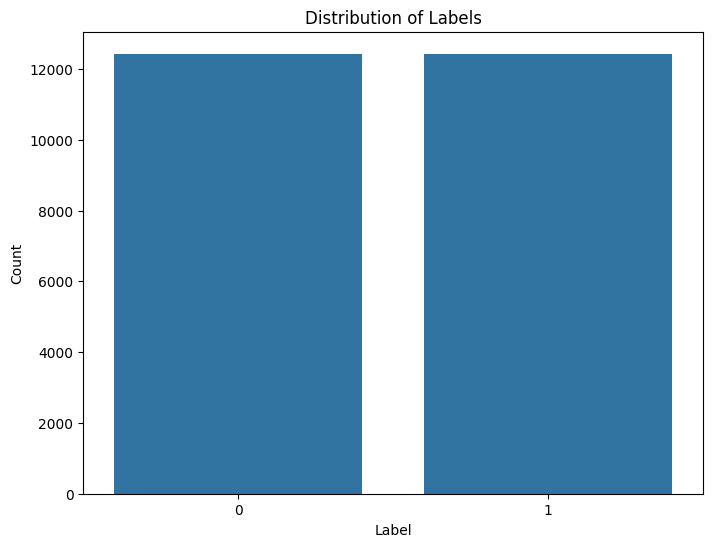

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def dataVisualization(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(x="label", data=df)
    plt.title("Distribution of Labels")
    plt.xlabel("Label")
    plt.ylabel("Count")
    labels = df.label.unique()  # Get unique labels from the DataFrame
    plt.xticks(ticks=range(len(labels)), labels=labels)  # Set tick labels
    plt.show()

# Call the function with train_df
dataVisualization(processed_data_train)


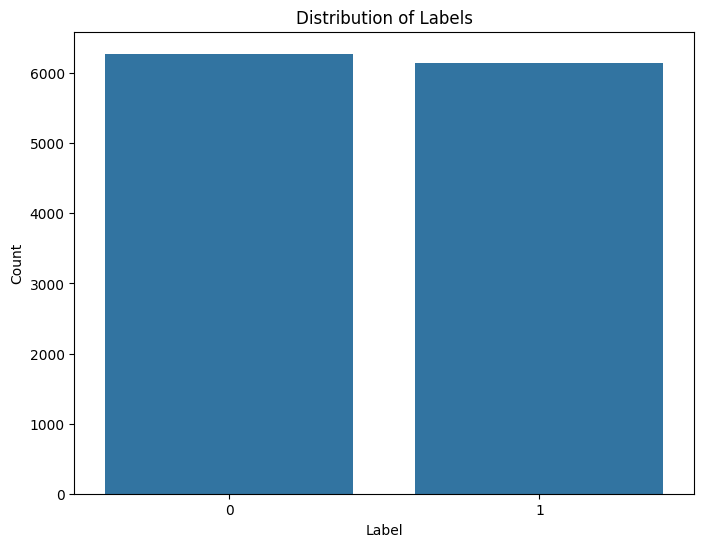

In [ ]:
# Call the function with val_df
dataVisualization(processed_data_val)

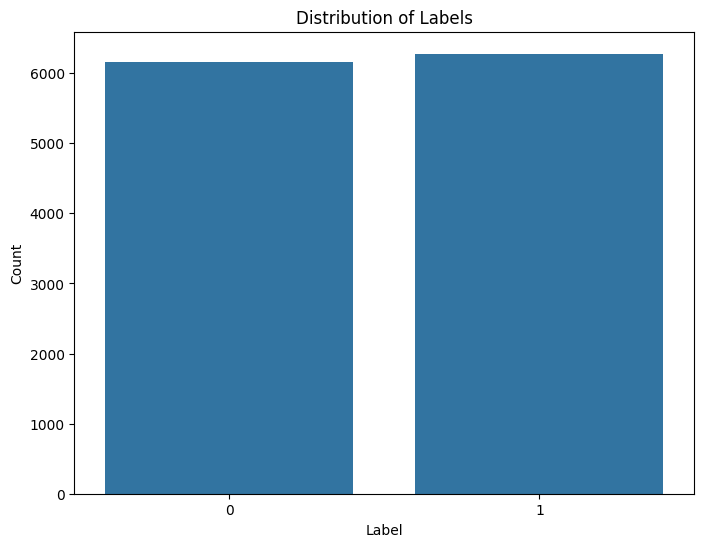

In [ ]:
# Call the function with val_df
dataVisualization(processed_data_test)

#Layer

##RoBERTa Layer

Byte-Pair Encoding (BPE)

In [ ]:
# import torch
# from transformers import RobertaTokenizer, RobertaModel

# # Load pre-trained RoBERTa base model and tokenizer
# model_name = "roberta-base"
# tokenizer_RoBERTa = RobertaTokenizer.from_pretrained(model_name)
# model_RoBERTa = RobertaModel.from_pretrained(model_name, output_hidden_states=True)

# def RoBERTa_Layer(text, tokenizer=tokenizer_RoBERTa, model=model_RoBERTa):
#     # Tokenize the input text and convert to input IDs and attention mask
#     inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
#     input_ids = inputs["input_ids"]
#     attention_mask = inputs["attention_mask"]

#     # Use torch.no_grad() to avoid computing gradients and save memory
#     with torch.no_grad():
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
#         # Only keep the last hidden state to save memory
#         last_hidden_state = outputs.hidden_states[-1]

#     return last_hidden_state

# test_RoBERTa_output = RoBERTa_Layer("hi im yen")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##LSTM Layer

In [ ]:
# import torch
# import torch.nn as nn

# class LSTM_Layer(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers, num_classes):
#         super(LSTM_Layer, self).__init__()
#         self.flatten = nn.Flatten()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 128)
#         self.fc2 = nn.Linear(128, num_classes)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # X shape: [n, 1, 512, 768]
#         x = x.squeeze(1)  # shape: [n, 512, 768]

#         # Flatten
#         x = self.flatten(x)  # shape: [n, 512*768]

#         # Reshape for LSTM
#         x = x.view(x.size(0), -1, 512*768)  # shape: [n, 1, 512*768]

#         # LSTM
#         h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)  # Initial hidden state
#         c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)  # Initial cell state

#         out, _ = self.lstm(x, (h0, c0))  # shape: [n, 1, hidden_size]

#         out = out[:, -1, :]  # shape: [n, hidden_size]

#         # Fully connected layers
#         out = self.relu(self.fc1(out))  # shape: [n, 128]
#         out = self.fc2(out)  # shape: [n, num_classes]

#         return out

# # Example usage
# n = 10  # Batch size
# input_size = 512 * 768
# hidden_size = 256
# num_layers = 2
# num_classes = 3

# model = LSTM_Layer(input_size, hidden_size, output_size=input_size, num_layers=num_layers, num_classes=num_classes)
# input_data = torch.randn(n, 1, 512, 768)  # Example input
# print(test_RoBERTa_output.shape)  # Should print torch.Size([n, 1, 512, 768]
# output = model(test_RoBERTa_output)
# print(output.shape)  # Should print torch.Size([n, num_classes])

torch.Size([1, 512, 768])
torch.Size([1, 3])


##RoBERTa + LSTM

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel

class RoBERTa_LSTM(nn.Module):
    def __init__(self, tokenizer, model, hidden_size, num_layers, num_classes):
        super(RoBERTa_LSTM, self).__init__()

        # Load pre-trained RoBERTa model and tokenizer
        self.tokenizer = tokenizer
        self.roberta = model

        # LSTM layer
        self.lstm = nn.LSTM(input_size=self.roberta.config.hidden_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        # Dense layers
        self.fc1 = nn.Linear(hidden_size * 2, 256)  # hidden_size * 2 for bidirectional LSTM
        self.fc2 = nn.Linear(256, num_classes)

        # Activation function
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_texts):
        # Tokenize input texts
        inputs = self.tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
        input_ids = inputs["input_ids"].to(self.roberta.device)
        attention_mask = inputs["attention_mask"].to(self.roberta.device)

        # Get RoBERTa hidden states
        with torch.no_grad():
            outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state  # shape: [batch_size, sequence_length, hidden_size]

        # LSTM layer
        h0 = torch.zeros(self.lstm.num_layers * 2, hidden_states.size(0), self.lstm.hidden_size).to(hidden_states.device)  # Initial hidden state for bidirectional LSTM
        c0 = torch.zeros(self.lstm.num_layers * 2, hidden_states.size(0), self.lstm.hidden_size).to(hidden_states.device)  # Initial cell state for bidirectional LSTM

        lstm_out, _ = self.lstm(hidden_states, (h0, c0))  # shape: [batch_size, sequence_length, hidden_size * 2]

        # Use the output of the last time step for each sequence in the batch
        lstm_out = lstm_out[:, -1, :]  # shape: [batch_size, hidden_size * 2]

        # Dropout layer
        dropout_out = self.dropout(lstm_out)

        # Fully connected layers
        fc1_out = self.relu(self.fc1(dropout_out))  # shape: [batch_size, 256]
        logits = self.fc2(fc1_out)  # shape: [batch_size, num_classes]

        # Apply softmax activation to get the probability distribution
        output = self.softmax(logits)

        return output

# Load pre-trained RoBERTa base model and tokenizer
model_name = "roberta-base"
tokenizer_RoBERTa = RobertaTokenizer.from_pretrained(model_name)
model_RoBERTa = RobertaModel.from_pretrained(model_name)

# Instantiate the model
model = RoBERTa_LSTM(tokenizer_RoBERTa, model_RoBERTa, hidden_size=256, num_layers=1, num_classes=3)

# Chuyển mô hình vào GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Dummy input: a list of 16 sentences
input_texts = ["This is sentence number " + str(i) for i in range(16)]
output = model(input_texts)

print(output.shape)  # Sẽ in ra torch.Size([16, num_classes])


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([16, 3])


# Dataset

In [ ]:
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

class TextDataset(Dataset):
    def __init__(self, texts, labels, transform=None):
        """
        texts: List of text samples
        labels: List of labels corresponding to the text samples
        transform: Optional transform to be applied on a sample
        """
        # Loại bỏ các câu có độ dài lớn hơn 512
        filtered_texts = []
        filtered_labels = []
        for text, label in zip(texts, labels):
            if len(text.split()) <= 512:  # Kiểm tra độ dài của câu
                filtered_texts.append(text)
                filtered_labels.append(label)

        self.texts = filtered_texts
        self.labels = filtered_labels
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        label_one_hot = torch.zeros(2)
        label_one_hot[label] = 1
        return text, label_one_hot

def collate_fn(batch):
    texts, labels = zip(*batch)
    return list(texts), torch.stack(labels)

In [ ]:
# # Sử dụng lớp TextDataset
# test_texts = ["This is sentence number " + str(i) for i in range(16)]
# test_labels = torch.randint(0, 3, (16,))
# test_dataset = TextDataset(test_texts, test_labels)
# test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False,collate_fn=collate_fn )
# # Iterate through the test dataloader
# for batch_text, batch_label in test_dataloader:
#     # Print the size and content of the batch
#     print("Size of batch_text:", batch_text)
#     print("Size of batch_label:", batch_label)

In [ ]:
# # Sử dụng lớp TextDataset
# test_texts = ["This is sentence number " + str(i) for i in range(16)]
# test_labels = torch.randint(0, 3, (16,))
# test_dataset = TextDataset(test_texts, test_labels)
# test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
# # Iterate through the test dataloader
# for batch_text, batch_label in test_dataloader:
#     # Print the size and content of the batch
#     print("Size of batch_text:", batch_text)
#     print("Size of batch_label:", batch_label)


In [ ]:
train_texts = processed_data_train['clean_text'].tolist()
train_labels = processed_data_train['label'].tolist()

valid_texts = processed_data_val['clean_text'].tolist()
valid_labels = processed_data_val['label'].tolist()

test_texts = processed_data_test['clean_text'].tolist()
test_labels = processed_data_test['label'].tolist()

In [ ]:
train_dataset = TextDataset(train_texts, train_labels)
valid_dataset = TextDataset(valid_texts, valid_labels)
test_dataset = TextDataset(test_texts, test_labels)

In [ ]:
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(valid_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Training dataset size: 24845
Validation dataset size: 12417
Test dataset size: 12441


In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

#Model

## Training model

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

def Train_model(model, loss_fn, optimizer, train_loader, val_loader, num_epochs=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Training device: ", device)

    # Chuyển model vào thiết bị hỗ trợ huấn luyện
    model.to(device)
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'=== EPOCH {epoch+1}/{num_epochs} ===')

        model.train()
        running_loss = 0.0

        # Duyệt từng batch
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (batch_input, batch_label) in progress_bar:
            optimizer.zero_grad() # xoá giá trị gradient cũ
            outputs = model(batch_input)
            batch_label = batch_label.squeeze()
            batch_label = batch_label.to(device)
            # print(f"train: batch_label: {batch_label}, output: {output}", )

            loss = loss_fn(outputs, batch_label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(batch_input)

        epoch_loss = running_loss / len(train_loader.dataset)

        # PHA kiểm nghiệm (validation)
        # --> đưa dữ liệu qua tập validation
        model.eval()   # # Đặt chế độ model là eval
        val_loss = 0.0
        val_preds, val_targets = [], []
        with torch.no_grad():
            progress_bar = tqdm(enumerate(val_loader), total=len(val_loader))
            for i, (batch_input, batch_label) in progress_bar:
                batch_label = batch_label.squeeze()
                batch_label = batch_label.to(device)

                outputs = model(batch_input)
                # print(f"val: batch_label: {batch_label}, output: {output}", )
                loss = loss_fn(outputs, batch_label)
                val_loss += loss.item() * len(batch_input)

                _, predictions = torch.max(outputs, 1)
                groung_truth = torch.argmax(batch_label, dim=1)

                val_preds.extend(predictions.cpu().numpy())
                val_targets.extend(groung_truth.cpu().numpy())

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)

        print(f'+ Training Loss: {epoch_loss:.4f}, ',
              f'+ Validation Loss: {val_loss:.4f}, ',
              f'+ Validation Accuracy: {val_acc:.4f}')

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Training complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s')

    return model

In [ ]:
import torch.optim as optim
# Example usage
batch_size = 16
hidden_size = 256
num_layers = 1
num_classes = 2

# Load pre-trained RoBERTa base model and tokenizer
model_name = "roberta-base"
tokenizer_RoBERTa = RobertaTokenizer.from_pretrained(model_name)
model_RoBERTa = RobertaModel.from_pretrained(model_name)

# Instantiate the model
model = RoBERTa_LSTM(tokenizer_RoBERTa, model_RoBERTa, hidden_size, num_layers, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
# train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1)
Train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=20)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== EPOCH 1/1 ===


  2%|▏         | 30/1553 [19:54<15:08:35, 35.80s/it]

In [ ]:
torch.save(model.state_dict(), "model.pth")

# Model Evaluation

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, dataloader, device):
    model.eval()  # Chuyển mô hình sang chế độ đánh giá
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            groung_truth = torch.argmax(labels, dim=1)

            # Ghi lại nhãn thực và nhãn dự đoán
            y_true.extend(groung_truth.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Tính các độ đo
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

In [ ]:
model.load_state_dict(torch.load("model.pth"))

# Chuyển mô hình và dữ liệu sang device (nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Gọi hàm evaluate_model để đánh giá mô hình
accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
